In [1]:
import numpy as np

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt


The probability distribution we wish to draw samples from.

$$ P(x, y) \propto \exp\left( \frac{-\left(\sqrt{x^2+y^2}-r_0\right)^2}{2}\right)  $$

In [12]:
def P(x, r0=5, w=1):
    """
    Target distribution, a ring/annulus in the 2D plane
    
    INPUTS
    ------
    r0, w: floats
        parameters of the distribution, the ring radius and thickness
    
    RETURNS
    -------
    Px: float
        the value of the PDF, P(x)
    """
    r = np.sqrt(x[0]**2+x[1]**2)
    return np.exp(-0.5*(r-r0)**2)


In [13]:
def Q(x, cov=np.identity(2)):
    """
    Proposal distribution, a 2D Gaussian centred on the current point
    
    INPUTS
    ------
    x: array
        the current point
    
    RETURNS
    -------
    X: array
        proposed point
    """
    X = multivariate_normal(x, cov).rvs()
    return X


# A simple implementation of the MCMC algorithm

In [27]:
# Initial starting point
x0 = np.array([0, 0])

# Create a chain of the points we have visited
chain = [x0]

# Number of iterations (or steps) to take
num_iterations = 5000

# iterate the algorithm
for i in range(num_iterations):
    
    # current point is last point in the chain
    x = chain[-1]
    
    # proposed point
    y = Q(x)
    
    # acceptance ratio
    alpha = P(y)/P(x)
    
    # random number determines acceptance
    u = np.random.uniform()
    
    if u<alpha: # accept the proposed point
        x_new = y
    else: # reject the proposed poont
        x_new = x
        
    # append new point to the chain
    chain.append(x_new)

# Plot the first few points in the MCMC chain

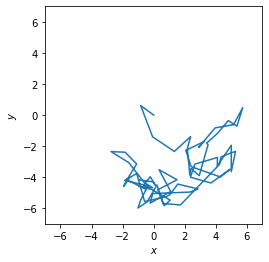

In [28]:
samples = np.array(chain)[0:100,:]

ax = plt.gca()
ax.set_aspect(1.)

ax.plot(samples[:,0], samples[:,1])

ax.set_xlim(-7,7)
ax.set_ylim(-7,7)

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

ax.set_aspect(1)

plt.show()

# Plot histogram of chain

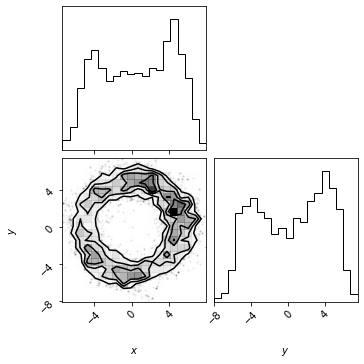

In [30]:
import corner 

samples = np.array(chain)

# remove a burnin portion of the chain and thin the rest of the chain
burnin = 100
thin = 10
thin_samples = samples[burnin::thin]

# plot histogram
corner.corner(samples, labels=[r'$x$', r'$y$'])

plt.show()

# Try rerunning the above with (i) more iterations (ii) different amounts of burnin and thinning.

# Using emcee package 

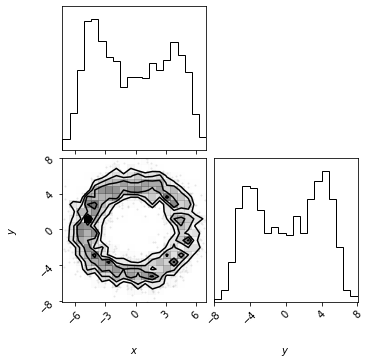

In [33]:
import emcee

ndim = 2 # our problem is 2 dimensional
nwalkers = 10 # instead of a single chain this algorithm uses several

x0 = np.random.randn(nwalkers, ndim) # choose random starting points 

# most sampling algorithms take the log of the PDF as input
def log_P(x):
    return np.log(P(x))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_P) # setup the sampler

state = sampler.run_mcmc(x0, 100) # run 100 burn in iterations

sampler.reset() 

sampler.run_mcmc(state, 5000) # run algorithm for 10000 iterations

samples = sampler.get_chain(flat=True, thin=20) # get the thinned mcmc chain

corner.corner(samples, labels=[r'$x$', r'$y$'])

plt.show()

In [38]:
import cpnest
from cpnest.model import Model

class Ring2D_Model(Model):
    """
    CPNest takes the input information as a class
    """
    names=['x','y']
    bounds=[[-10,10],[-10,10]]

    def log_likelihood(self, params):
        r = np.sqrt(params['x']**2 + params['y']**2)
        return -0.5*(r-r0)**2
    
model = Ring2D_Model()
nest = cpnest.CPNest(model)
nest.run()

2021-11-01, 10:34:19 - CPNest  : Running with 8 parallel threads


KeyboardInterrupt: 